In [1]:
!conda install gdcm -c conda-forge -y
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pydicom
import glob
from tqdm.notebook import tqdm
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
from skimage import exposure
#import gdcm
import cv2
import warnings
from fastai.vision.all import *
from fastai.medical.imaging import *
warnings.filterwarnings('ignore')
dataset_path = Path('../input/siim-covid19-detection')
import vtk
# numba
import numba
from numba import jit
from vtk.util import numpy_support

reader = vtk.vtkDICOMImageReader()

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdcm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.3               |   py37h89c1867_1         3.0 MB  conda-forge
    gdcm-2.8.9                 |   py37hbd440ad_3         3.4 MB  conda-forge
    json-c-0.15                |       h98cffda_0         274 KB  conda-forge
    libjpeg-turbo-2.1.0        |       h7f98852_0         987 KB  conda-forge
    -------------------------------------------------------

In [2]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
   
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to 
    # "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data
        
    
def plot_img(img, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()


def plot_imgs(imgs, cols=4, size=7, is_rgb=True, title="", cmap='gray', img_size=(500,500)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()
    


def image_path(row):
    study_path = dataset_path/'train'/row.StudyInstanceUID
    for i in get_dicom_files(study_path):
        if row.id.split('_')[0] == i.stem: return i 
        



class Config:
    n_folds: int = 5
    seed: int = 2021
    num_classes: int = 2 
    img_size: int = 256
    fold_num: int = 0
    device: str = 'cuda:0'



def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(Config.seed)

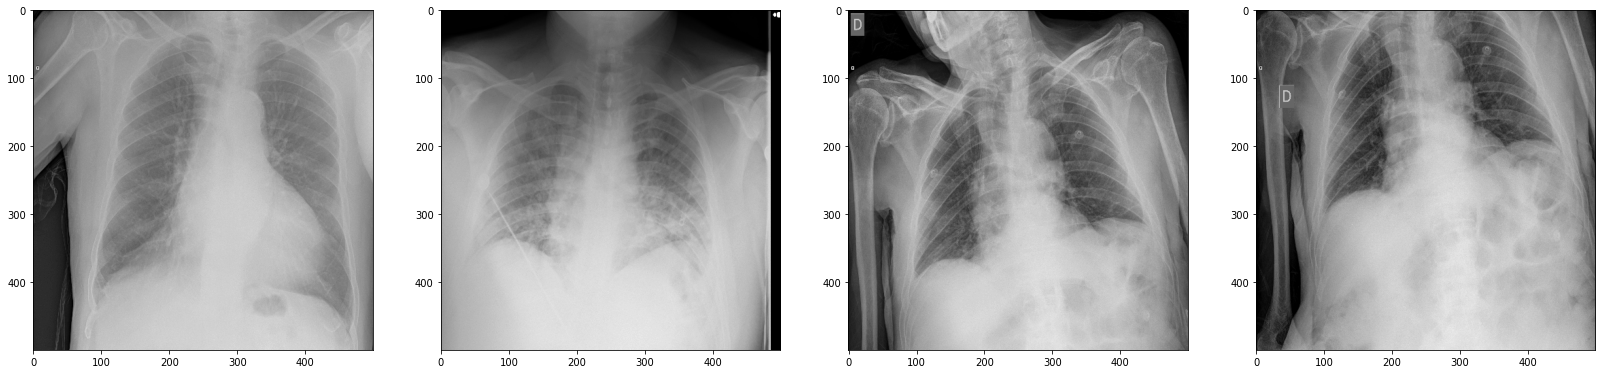

In [3]:
dicom_paths = get_dicom_files(dataset_path/'train')
imgs = [dicom2array(path) for path in dicom_paths[:4]]
plot_imgs(imgs)

In [4]:
train_image_df = pd.read_csv(dataset_path/'train_image_level.csv')
train_image_df['class'] = train_image_df.label.apply(lambda x: x.split()[0])
train_image_df['x_min'] = train_image_df.label.apply(lambda x: float(x.split()[2]))
train_image_df['y_min'] = train_image_df.label.apply(lambda x: float(x.split()[3]))
train_image_df['x_max'] = train_image_df.label.apply(lambda x: float(x.split()[4]))
train_image_df['y_max'] = train_image_df.label.apply(lambda x: float(x.split()[5]))
train_image_df['image_path'] = train_image_df.apply(image_path, axis=1)

In [5]:
image_ids = train_image_df['id'].unique()
valid_ids = image_ids[-5000:]
train_ids = image_ids[:-5000]



In [6]:
valid_df = train_image_df[train_image_df['id'].isin(valid_ids)]
train_df = train_image_df[train_image_df['id'].isin(train_ids)]

train_df["class_id"] = [1]*len(train_df)
valid_df["class_id"] = [1]*len(valid_df)
print(len(train_image_df))
print(train_df.shape)
train_df.head(2)

6334
(1334, 11)


,id,boxes,label,StudyInstanceUID,class,x_min,y_min,x_max,y_max,image_path,class_id
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,opacity,789.28836,582.43035,1815.94498,2499.73327,../input/siim-covid19-detection/train/5776db0cec75/81456c9c5423/000a312787f2.dcm,1
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,none,0.00000,0.00000,1.00000,1.00000,../input/siim-covid19-detection/train/ff0879eb20ed/d8a644cc4f93/000c3a3f293f.dcm,1


In [7]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import pydicom
import warnings

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from pydicom import dcmread

from matplotlib import pyplot as plt
import random
paddingSize= 0

In [8]:
class COVIDTrainDataLoader(Dataset): #Class to load Training Data
    
    def __init__(self, dataframe, transforms=None,stat = 'Train'):
        super().__init__()
        
        self.image_ids = dataframe["id"].unique()
        
        self.df = dataframe
        self.transforms = transforms
        self.stat = stat
        
    def __getitem__(self, index):
        if self.stat == 'Train':
            
            image_id = self.image_ids[index]
            
            records = self.df[(self.df['id'] == image_id)]
            records = records.reset_index(drop=True)
            image = dicom2array(self.df[(self.df['id'] == image_id)]['image_path'].values[0])


           
            '''if "PhotometricInterpretation" in dicom:
                if dicom.PhotometricInterpretation == "MONOCHROME1":
                    image = np.amax(image) - image'''

            intercept =  0.0
            slope =1.0

            if slope != 1:
                image = slope * image.astype(np.float64)
                image = image.astype(np.int16)

            
            image += np.int16(intercept)        

            image = np.stack([image, image, image])
            image = image.astype('float32')
            image = image - image.min()
            image = image / image.max()
            image = image * 255.0
            image = image.transpose(1,2,0)

            if records.loc[0, "class_id"] == 0:
                records = records.loc[[0], :]

            boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)
            labels = torch.tensor(records["class_id"].values, dtype=torch.int64)

            # suppose all instances are not crowd
            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            #target['id'] = torch.tensor([index])
            #target['area'] = area
            #target['iscrowd'] = iscrowd

            if self.transforms:
                sample = {
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                }
                sample = self.transforms(**sample)
                image = sample['image']

                target['boxes'] = torch.tensor(sample['bboxes'])

            if target["boxes"].shape[0] == 0:
                # Albumentation cuts the target (class 14, 1x1px in the corner)
                target["boxes"] = torch.from_numpy(np.array([[0.0, 0.0, 1.0, 1.0]]))
                #target["area"] = torch.tensor([1.0], dtype=torch.float32)
                target["labels"] = torch.tensor([0], dtype=torch.int64)
            
            return image, target, image_ids
        
        else:
                   
            image_id = self.image_ids[index]
            records = self.df[(self.df['id'] == image_id)]
            records = records.reset_index(drop=True)

            image = dicom2array(self.df[(self.df['id'] == image_id)]['image_path'].values[0])#dcmread

            #image = ds.pixel_array

            intercept =  0.0
            slope = 1.0

            if slope != 1:
                image = slope * image.astype(np.float64)
                image = image.astype(np.int16)

            image += np.int16(intercept)        

            image = np.stack([image, image, image])
            image = image.astype('float32')
            image = image - image.min()
            image = image / image.max()
            image = image * 255.0
            image = image.transpose(1,2,0)

            if self.transforms:
                sample = {
                    'image': image,
                }
                sample = self.transforms(**sample)
                image = sample['image']

            return image, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

In [9]:
def get_train_transform():
    return A.Compose([
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, p=0.25),
        A.LongestMaxSize(max_size=800, p=1.0),
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_test_transform():
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ])

In [10]:
train_dataset = COVIDTrainDataLoader(train_df, get_train_transform())
train_dataset

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = COVIDTrainDataLoader(train_df, get_train_transform())
valid_dataset = COVIDTrainDataLoader(valid_df, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()
# Create train and validate data loader
train_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [12]:
train_data_loader

In [13]:
#for images, targets, image_ids in train_data_loader:
  #  print(targets)

In [14]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [15]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [16]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

num_epochs =  1 #low epoch to save GPU time

In [17]:
loss_hist = Averager()
itr = 1
lossHistoryiter = []
lossHistoryepoch = []

import time
start = time.time()

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #print(targets)
        loss_dict = model(images, targets)  
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)
        lossHistoryiter.append(loss_value)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    lossHistoryepoch.append(loss_hist.value)
    print(f"Epoch #{epoch} loss: {loss_hist.value}")   
    
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Time taken to Train the model :{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Iteration #50 loss: 0.24040748605330536
Iteration #100 loss: 0.19040104406140967
Iteration #150 loss: 0.12275177451638661
Iteration #200 loss: 0.24834414180672007
Iteration #250 loss: 0.10450436574044725
Iteration #300 loss: 0.28923685971285584
Iteration #350 loss: 0.3355243133886412
Iteration #400 loss: 0.24005204141006706
Iteration #450 loss: 0.1936212934779668
Iteration #500 loss: 0.17901627892030716
Iteration #550 loss: 0.18499771716568345
Iteration #600 loss: 0.22240768037353412
Iteration #650 loss: 0.1266247045819812
Epoch #0 loss: 0.2519383090130318
Time taken to Train the model :00:11:38.79


In [18]:
import plotly.graph_objects as go

x = [i for i in range(num_epochs)]
y = lossHistoryepoch
fig = go.Figure()
fig.add_trace(go.Scatter(x=x,y=y,
                    mode='lines',
                    name='lines'))

fig.update_layout(title='Loss vs Epochs',
                   xaxis_title='Epochs',
                   yaxis_title='Loss')
fig.show()

In [19]:
PATH = "FRCNN.pt"
torch.save(model, PATH)

In [20]:
test_df = pd.read_csv('../input/siim-covid19-detection/sample_submission.csv')

def study_path(row):
    study_path = dataset_path/'test'/row.id.split("_")[0]
    for i in get_dicom_files(study_path):
        return i 
        
test_df['image_path'] = test_df.apply(study_path, axis=1)
test_df["image_path"] = test_df["image_path"].apply(str)
test_df.head()

,id,PredictionString,image_path
0,00188a671292_study,negative 1 0 0 1 1,../input/siim-covid19-detection/test/00188a671292/3eb5a506ccf3/3dcdfc352a06.dcm
1,004bd59708be_study,negative 1 0 0 1 1,../input/siim-covid19-detection/test/004bd59708be/e7d024ea82d7/c39146cbda47.dcm
2,00508faccd39_study,negative 1 0 0 1 1,../input/siim-covid19-detection/test/00508faccd39/d39fc1121992/951211f8e1bb.dcm
3,006486aa80b2_study,negative 1 0 0 1 1,../input/siim-covid19-detection/test/006486aa80b2/fe138b3d009e/5e0e7acd9c7d.dcm
4,00655178fdfc_study,negative 1 0 0 1 1,../input/siim-covid19-detection/test/00655178fdfc/2e01129e9043/5b8ee5baa1d5.dcm


In [21]:
def image_file_path(row):
    s = row.id.split("_")[0]

    try:
        return test_df.loc[test_df["image_path"].str.contains(s)]["image_path"].values[0]
    except:
        print(s)
        return ""

In [22]:
cpu_device = torch.device("cpu")

In [23]:
test_dataset = COVIDTrainDataLoader(test_df, get_test_transform(),"Test")

test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=1,
    drop_last=False,
    collate_fn=collate_fn
)

In [24]:
def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))

    return " ".join(pred_strings)

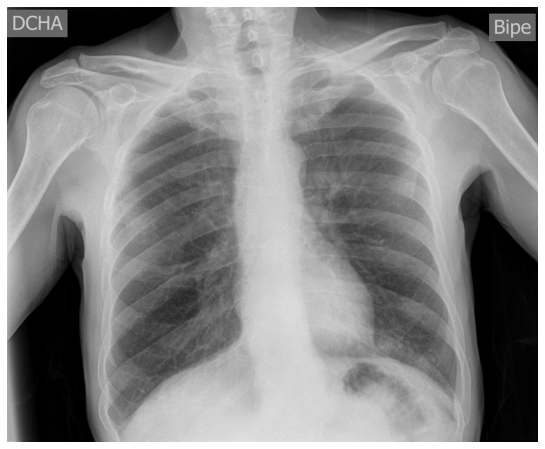

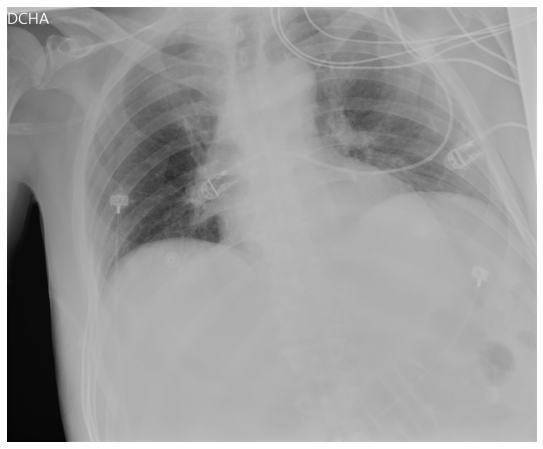

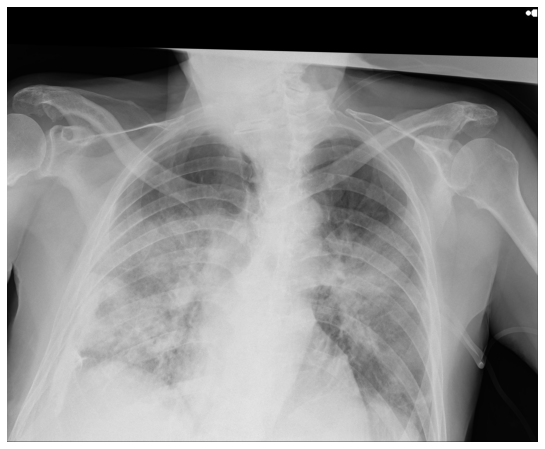

In [25]:
images, image_ids = next(iter(test_data_loader))
images = list(image.to(device) for image in images)

for number in random.sample([1,2,3],3):
  img = images[number].permute(1,2,0).cpu().numpy()
  #labels= targets[number]['labels'].cpu().numpy().astype(np.int32)
  fig, ax = plt.subplots(1, 1, figsize=(16, 8))
  ax.set_axis_off()
  ax.imshow(img)

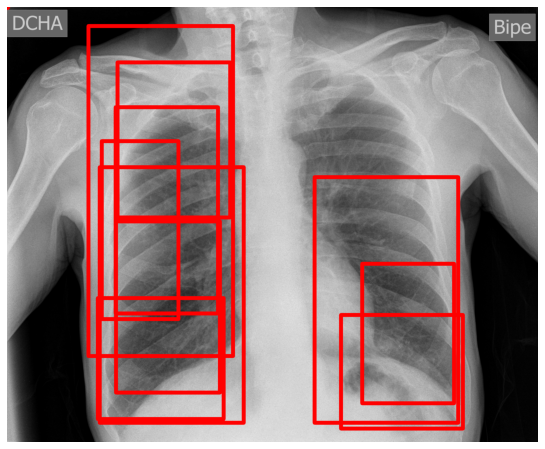

In [26]:
model.eval()
images = list(img.to(device) for img in images)

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]


boxes = outputs[2]['boxes'].cpu().detach().numpy().astype(np.int32)
img = images[2].permute(1,2,0).cpu().detach().numpy()
labels= outputs[2]['labels'].cpu().detach().numpy().astype(np.int32)
score = outputs[2]['scores']

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

img = cv2.cvtColor(np.float32(img), cv2.COLOR_RGB2BGR)
for i in range(len(boxes)):
  img = cv2.rectangle(img,(boxes[i][0]+paddingSize,boxes[i][1]+paddingSize),(boxes[i][2]+paddingSize,boxes[i][3]+paddingSize),(255,0,0),20)
  #img = cv2.putText(img, label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])), cv2.FONT_HERSHEY_TRIPLEX,3, (255,0,0), 3, cv2.LINE_AA)

ax.set_axis_off()
ax.imshow(img)

In [27]:
outputs 

[{'boxes': tensor([[7.9352e+02, 1.2147e+03, 1.8340e+03, 2.3852e+03],
          [7.3158e+02, 5.2951e+02, 1.9825e+03, 2.6422e+03],
          [8.2841e+02, 1.5957e+03, 1.9444e+03, 2.6449e+03],
          [8.4435e+02, 7.3725e+02, 1.6942e+03, 2.1652e+03],
          [7.7459e+02, 1.6757e+03, 1.5431e+03, 2.3264e+03],
          [1.0327e+03, 1.7282e+03, 1.7560e+03, 2.3271e+03],
          [6.8292e+02, 1.3683e+03, 1.3896e+03, 2.4636e+03],
          [2.9716e+03, 1.5866e+03, 3.6563e+03, 2.6315e+03],
          [1.0137e+03, 2.0117e+03, 1.7219e+03, 2.3964e+03],
          [2.4403e+03, 4.9059e+02, 3.6996e+03, 2.7615e+03],
          [7.9985e+02, 1.4930e+03, 1.4421e+03, 2.1026e+03],
          [3.0716e+03, 2.0353e+03, 3.6469e+03, 2.6316e+03],
          [4.2270e+03, 3.8053e-01, 4.2375e+03, 1.0618e+01],
          [2.8368e+03, 1.0389e+03, 3.5591e+03, 2.3941e+03],
          [8.1356e+02, 1.1411e+03, 1.2621e+03, 1.9461e+03]],
         grad_fn=<CopyBackwards>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,